In [1]:
import sklearn
import numpy as np
import os

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Clustering

## Classification _vs_ Clustering

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

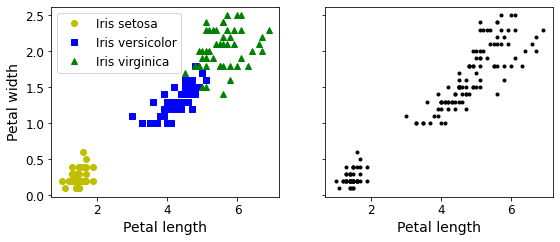

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

Дане зображення ілюструє різницю даних у задачах класифікації та кластеризації: у першому випадку відгуки є відомими (для навчальної вибірки), а у другому - ні.

Застосуємо Gaussian mixture model. Вона розбиває дані на кластери досить близько до значення класів.

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([1, 2, 0])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

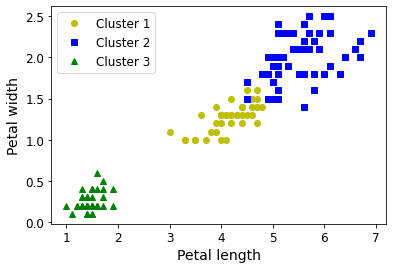

In [7]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [22]:
len(y_pred) - np.sum(y_pred==y)

145

In [19]:
1 - (np.sum(y_pred==y) / len(y_pred)) # accuracy

0.9666666666666667

## K-Means

Почнемо з генерації датасету:

In [23]:
from sklearn.datasets import make_blobs

In [24]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [25]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Візуалізуємо:

In [26]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

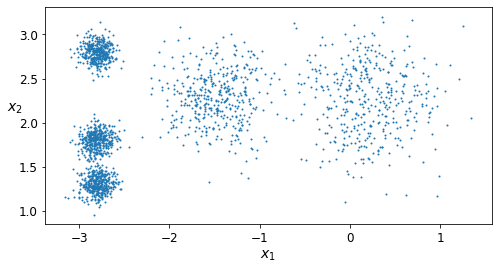

In [27]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

### Натренуємо K-Means

In [28]:
from sklearn.cluster import KMeans

In [29]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Кожний елемент був асоційованим з одним з 5 кластерів:

In [30]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

kmeans.labels_ містить id кластерів, асоційованих з елементами тренувальної вибірки:

In [31]:
y_pred is kmeans.labels_

True

Центроїди кластерів:

In [32]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Звісно, ми також можемо асоціювати нові дані з існуючими кластерами шляхом знаходження найближчого центроїда:

In [33]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

### Межі рішень

Межі рішень утворюють _діаграму Вороного_:

In [34]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

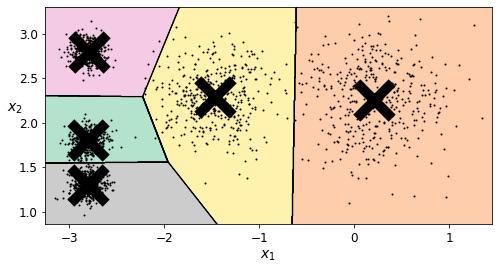

In [35]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

### Hard Clustering _vs_ Soft Clustering

Замість присвоєння кластера елементу вибірки, ми могли б порівняти відстані до відповідних центрів, і таким чином отримати т.з. м'яку кластеризацію. Для цього використаємо функцію `transform()`:

In [36]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

Дійсно, це відстань до центроїдів:

In [37]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### Вплив ініціалізації на K-Means

In [38]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

C:\soft\Anaconda\envs\stats\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\soft\Anaconda\envs\stats\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


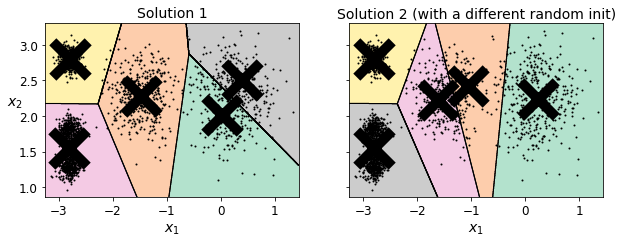

In [39]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

### Інерція

Для порівняння розбиттів на кластери введемо метрику, що називається інерція: суму відстаней від елементів до центроїдів відповідних кластерів:

In [40]:
kmeans.inertia_

211.59853725816836

Дійсно:

In [41]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

Метож `score()` повертає від'ємну інерцію:

In [42]:
kmeans.score(X)

-211.59853725816834

### Оптимальна кількість кластерів

Розглянемо тепер кількість кластерів, відмінну від 5

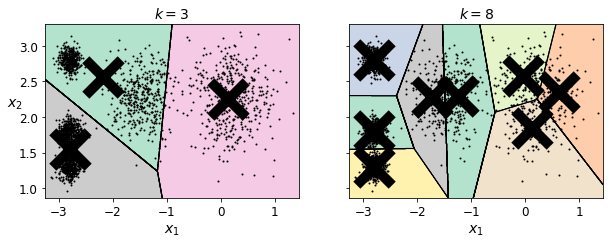

In [43]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

Обчисливо відповідну інерцію

In [44]:
kmeans_k3.inertia_

653.2167190021554

In [45]:
kmeans_k8.inertia_

119.11983416102879

Інерція лише спадатиме зі зростанням кільксті кластрів, і не може прямо слугувати для визначення оптимальної кількості кластерів. Натомість, зобразимо графік залежності інерції від кількості кластерів:

In [46]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

C:\soft\Anaconda\envs\stats\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


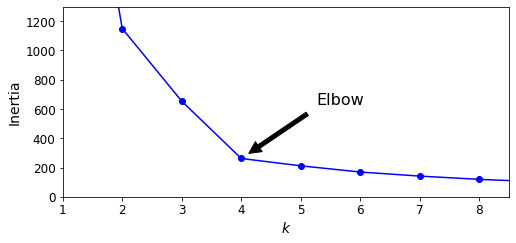

In [47]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

Як ми бачимо, цей графік має "лікоть" при $k=4$, що означає, що при подальшому збільшенні кількості кластрів інерція починає спадати повільно. Можемо припустити, що $k=4$ є хорошим наближення оптимальної кількості кластерів.

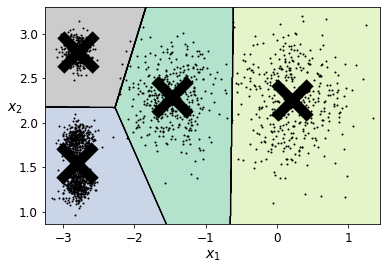

In [48]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Інша метрика - це _silhouette score_, що визначається як середнє знання _silhouette coefficient_ у датасетів. В свою чергу, silhouette coefficient елемента дорівнює $(b - a)/\max(a, b)$ де $a$ є середньою відстанню від елемента до елементів свого кластера, а $b$ є is середньою відстанню від елемента до елементів найближчого сусіднього кластера. Значення silhouette coefficient варіюється від -1 до +1.

Зобразимо silhouette score як функцію від $k$:

In [49]:
from sklearn.metrics import silhouette_score

In [50]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [53]:
# the higher score - the better
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

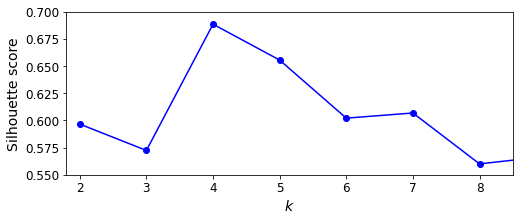

In [54]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

Дана діаграма вказує, що і $k=4$, і $k=5$ є хорошим вибором.

###  _Silhouette diagram_

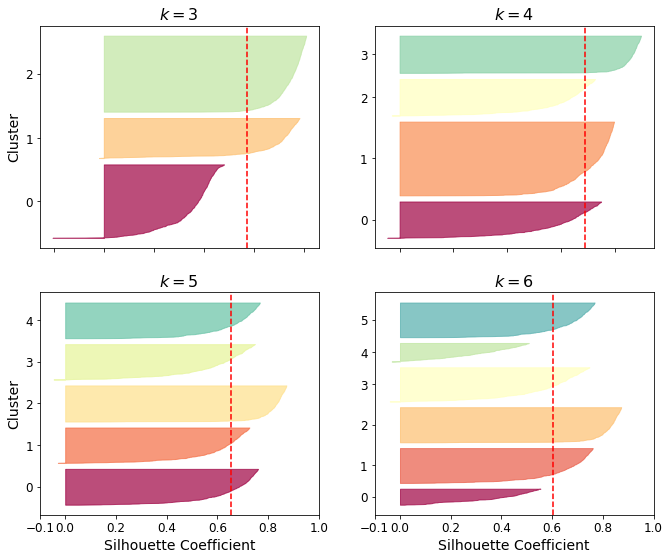

In [55]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

### K-Means та кластери "неправильної" форми

K-Means погано справляється з близько розташованими кластерами неправильної форми, або різних розмірів

In [56]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

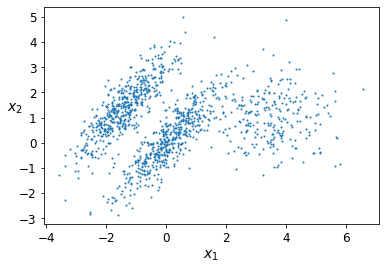

In [57]:
plot_clusters(X)

In [58]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

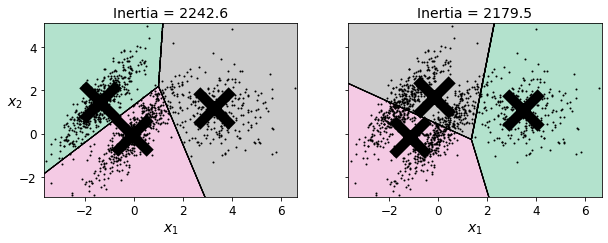

In [59]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

### Кластеризація для сегментації зображень

In [60]:
import urllib
filename = "ladybug.png"

url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/images/unsupervised_learning/ladybug.png"
urllib.request.urlretrieve(url,  filename)

('ladybug.png', <http.client.HTTPMessage at 0x2aae9846250>)

In [61]:
from matplotlib.image import imread
image = imread(filename)
image.shape

(533, 800, 3)

In [62]:
# takes couple of seconds
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [63]:
# takes ~20 seconds
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

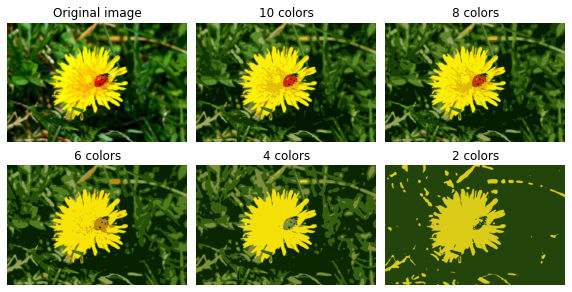

In [64]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()

# Завдання

*Завдання 1: Завантажте MNIST . Розбийте його на навчальну, валідаційну та тренувальну вибірку. Застосуйте PCA для зменшення розмірності.*

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression

In [2]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

C:\Users\Pavlo\anaconda3\envs\studying\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [11]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shapes of the resulting datasets
print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Validation set shape: {X_val.shape}, {y_val.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')

Training set shape: (56000, 784), (56000,)
Validation set shape: (7000, 784), (7000,)
Test set shape: (7000, 784), (7000,)


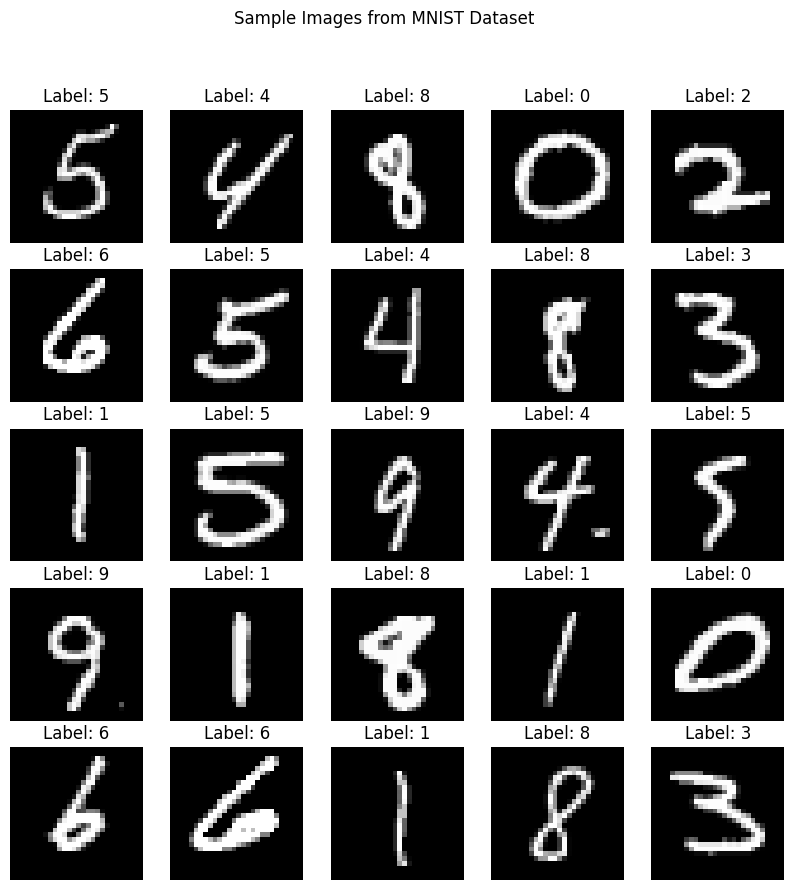

In [10]:
# Function to plot sample images from the dataset
def plot_samples(X, y, title):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {y[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot some sample images from the original dataset
plot_samples(X_train.to_numpy(), y_train.to_numpy(), 'Sample Images from MNIST Dataset')

In [7]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [8]:
# Check the shapes of the resulting datasets
print(f'Training set shape: {X_train_pca.shape}, {y_train.shape}')
print(f'Validation set shape: {X_val_pca.shape}, {y_val.shape}')
print(f'Test set shape: {X_test_pca.shape}, {y_test.shape}')

Training set shape: (56000, 50), (56000,)
Validation set shape: (7000, 50), (7000,)
Test set shape: (7000, 50), (7000,)


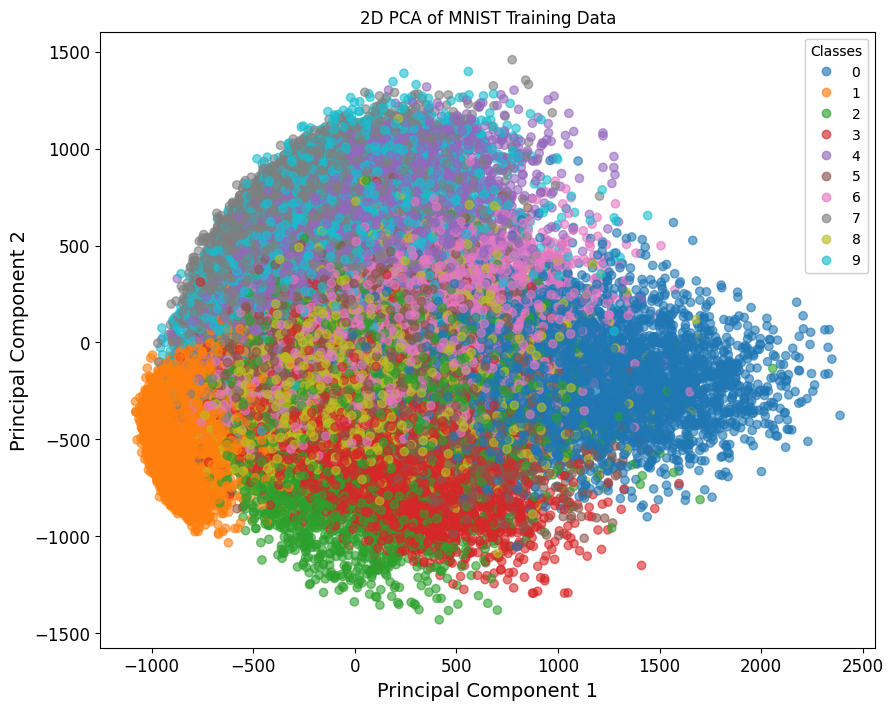

In [17]:
def plot_pca(X_pca, y, title):
    y = y.to_numpy()  # Convert to numpy array if it's a Pandas Series
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6)
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.show()

# Apply PCA to reduce to 2 dimensions for visualization
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

# Plot the 2D PCA reduced dimensions
plot_pca(X_train_pca_2d, y_train, '2D PCA of MNIST Training Data')

*Завдання 2: Кластеризуйте тренувальну вибірку після зменшення розмірності, використовуючи K-Means. Знайдіть оптимальну кількість кластерів (elbow method/silhouette score)*

In [18]:
# Finding the optimal number of clusters using the elbow method
sse = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_pca, kmeans.labels_))

C:\Users\Pavlo\anaconda3\envs\studying\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pavlo\anaconda3\envs\studying\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pavlo\anaconda3\envs\studying\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pavlo\anaconda3\envs\studying\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init

In [19]:
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f'Optimal number of clusters: {optimal_k}')

Optimal number of clusters: 2


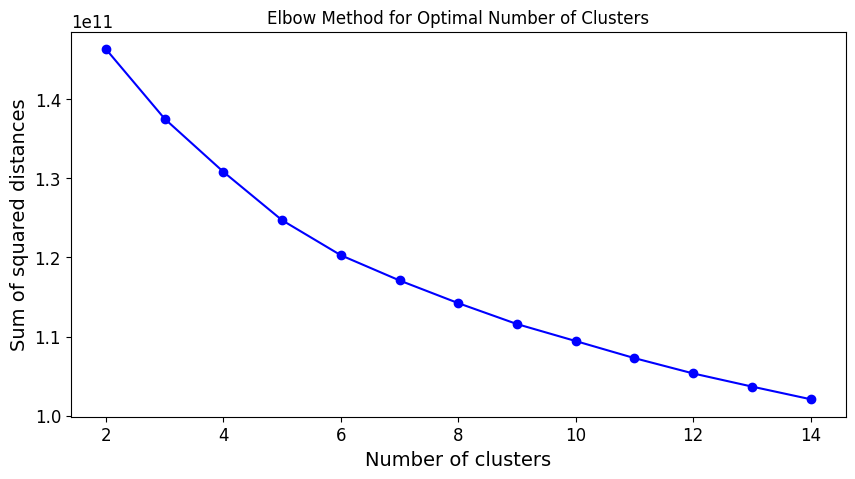

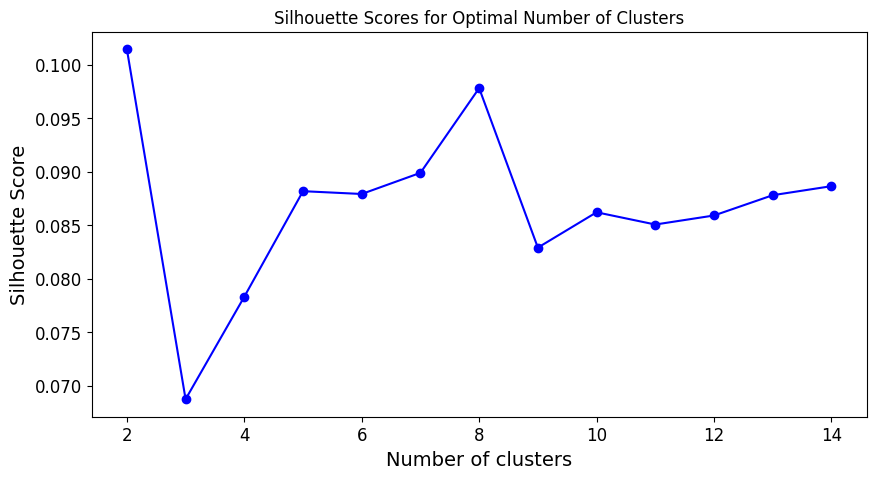

In [20]:
# Plotting the elbow method graph
plt.figure(figsize=(10, 5))
plt.plot(K, sse, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Plotting the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.show()

In [21]:
# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_train_pca)
clusters = kmeans.predict(X_train_pca)

# Visualize the clusters
def plot_clusters(X_pca, clusters, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.show()

C:\Users\Pavlo\anaconda3\envs\studying\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


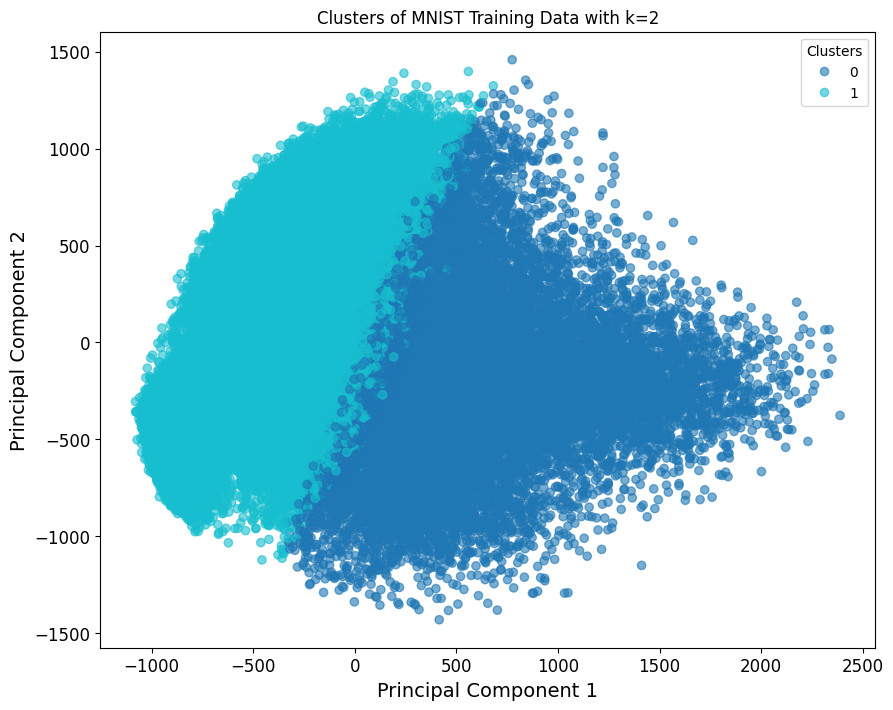

In [22]:
# Apply PCA to reduce to 2 dimensions for visualization
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

# Plot the clusters
plot_clusters(X_train_pca_2d, clusters, f'Clusters of MNIST Training Data with k={optimal_k}')